In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import seaborn as sns
import os

In [2]:
FIG_PREFIX = 'revision2/traffic'
ALL_METHODS = ['BEST', 'FREE', 'LPMS', 'Trigram', 'VGGraph']

In [3]:
rev_dir = '../result/revision/traffic'

In [4]:
trigram_dir = '../result/trigram_result/result/traffic_trigram_result'
vggraph_dir = '../result/vggraph_result/traffic_vggraph_greedy_revision'

In [5]:
root_dir = '../result/traffic_result_new2'
root_best_dir = '../result/traffic_best_result'
root_free_dir = '../result/traffic_free_result2'
root_lpms_dir = '../result/traffic_lpms_result'
root_missing_dir = '../result/missing_result/missing_traffic_result'
id_cols = ['name', 'num_threads', 'gram_size', 'selectivity', 'num_keys']

In [6]:
def build_stats_filename(row, previous_version, reduced):
    name = row['name']
    if 'parallel' in name:
        name = name.split('-')[0]
    if 'VGGraph-Greedy' in name:
        name = 'VGGRAPH'
    fields = [name, str(int(row['num_threads'])), str(int(row['gram_size'])), str(row['selectivity'] if row['selectivity'] > 0 else -1), 'stats.csv']
    if 'Trigram' in name:
        fields[2] = '-1'
    if not previous_version:
        if reduced is not None:
            fields.insert(-1, str(reduced))
        elif 'BEST' in name:
            fields.insert(-1, '-1')
    space_file = f"time_report_"
    if 'LPMS' in name:
        space_file += f"lpms_t{row['num_threads']}"
        space_file += '_determ' if 'DETER' in name else '_random'
        # max_num = -1
    else:
        if 'VGGraph-Greedy' in row['name']:
            space_file += f"{row['name'].lower().replace('-', '_')}_t{int(row['num_threads'])}"
        else:
            space_file += f"{name.lower()}_t{int(row['num_threads'])}"
        if reduced is not None:
            space_file += f"_red{reduced/1000:g}"
        if 'Trigram' not in name:
            space_file += f"_c{row['selectivity']}"
        if 'FREE' in name or 'VG' in name:
            space_file += f"_n{int(row['gram_size'])}"
    if 'key_upper_bound' in row:
            space_file += f"_{int(row['key_upper_bound'])}"
            fields.insert(-1, str(int(row['key_upper_bound'])))
    space_file += '.txt'
    return '_'.join(fields), space_file   

In [7]:
def get_compute_space(space_f, root_dir=root_dir):
    fullname = os.path.join(root_dir, space_f)
    try:
        with open(fullname, 'r') as file:
            for line in file:
                if 'Maximum resident set size (kbytes)' in line:
                    return int(line.strip().split(': ')[-1].strip())
    except:
        print(f'Error reading file {fullname}')
        pass
    return -1

In [8]:
def get_stats_df(row, previous_version=False, reduced=None, root_dir=root_dir):
    fname, space_f = build_stats_filename(row, previous_version, reduced)
    return pd.read_csv(os.path.join(root_dir, fname), sep='\t'), get_compute_space(space_f, root_dir)

In [9]:
def add_num_after_filter(df, previous_version=False, reduced_list=None, root_dir=root_dir):
    new_cols = {
        'num_after_filter': [],
        'per_query_num_after_filter': [],
        'match_count': [],
        'compute_size': []
    }
    idx = 0
    reduced = None
    if reduced_list is not None:
        assert(reduced_list is None or len(reduced_list) == df.shape[0])
    for _, row in df.iterrows():
        if reduced_list is not None:
            reduced = reduced_list[idx]
            idx += 1
        detail_df, compute_size = get_stats_df(row, previous_version, reduced=reduced, root_dir=root_dir)
        new_cols['num_after_filter'].append(detail_df['num_after_filter'].sum())
        new_cols['per_query_num_after_filter'].append(detail_df['num_after_filter'].mean())
        new_cols['match_count'].append(detail_df['count'].sum())
        new_cols['compute_size'].append(compute_size)
    return df.assign(**new_cols)

In [15]:
def build_result_df(root_dir, previous_version=False, reduced=None):
    summary_path = os.path.join(root_dir, 'summary.csv')
    summary_df = pd.read_csv(summary_path)
    summary_df.ffill(inplace=True)
    summary_df = summary_df.fillna(-1)

    summary_df['overall_match_time'] = summary_df['compile_time'] + summary_df['match_time']
    summary_df.rename(columns={'overall_time': 'overall_index_time', '    name': 'name'}, inplace=True)
    summary_df['overall_time'] = summary_df['overall_index_time'] + summary_df['overall_match_time']
    # code for getting end-to-end trimmed mean
    summary_df = add_num_after_filter(summary_df, previous_version=previous_version, reduced_list=reduced, root_dir=root_dir)
    res = summary_df.sort_values('overall_time')
    gb = res.groupby(by=id_cols)
    if gb.count()['selection_time'].min() > 2:
        res = res.drop(gb.tail(1).index)
        res = res.drop(gb.head(1).index)
    res_df = res.groupby(by=id_cols, as_index=False).min(numeric_only=True).apply(lambda x: x)
    return res_df

In [ ]:
res_df1 = build_result_df(root_dir, previous_version=True)
res_df1 = res_df1.loc[~((res_df1['gram_size'] == 2) & (res_df1['selectivity'] == 0.7))] 
res_df1 = res_df1.loc[~((res_df1['gram_size'] == 4) & (res_df1['selectivity'] == 0.3))] 

In [17]:
res_dfrev = build_result_df(rev_dir)

In [19]:
res_trigram = build_result_df(trigram_dir)

In [32]:
res_trigram

,name,num_threads,gram_size,selectivity,num_keys,key_upper_bound,num_queries,selection_time,build_time,overall_index_time,index_size,compile_time,match_time,overall_match_time,overall_time,num_after_filter,per_query_num_after_filter,match_count,compute_size
0,Trigram,16,3,-1,5,5,4,0.000778,0.494188,0.494967,2432238,0.000150,4.981967,4.982117,5.477084,11381372,2845343.00,368166,682924
1,Trigram,16,3,-1,10,10,4,0.000752,0.611890,0.612642,7140164,0.000151,4.982686,4.982837,5.595479,11381372,2845343.00,368166,722840
2,Trigram,16,3,-1,15,15,4,0.000594,0.693126,0.693720,31049018,0.000152,4.957476,4.957628,5.651348,11381372,2845343.00,368166,826092
3,Trigram,16,3,-1,45952,-1,4,4.615590,14.393800,19.009400,1354194104,0.000165,1.418142,1.418307,20.427707,375447,93861.75,368168,12707656


In [21]:
res_vggraph = build_result_df(vggraph_dir)

In [22]:
res_lpms_df = build_result_df(root_lpms_dir)

In [23]:
res_best_df = build_result_df(root_best_dir)

In [24]:
res_free_df = build_result_df(root_free_dir)

In [25]:
res_missing_df = build_result_df(root_missing_dir)

Error reading file ../result/missing_result/missing_traffic_result/time_report_free_t10_c0.3_n4_-1.txt
Error reading file ../result/missing_result/missing_traffic_result/time_report_free_t10_c0.3_n4_-1.txt
Error reading file ../result/missing_result/missing_traffic_result/time_report_free_t10_c0.3_n4_-1.txt
Error reading file ../result/missing_result/missing_traffic_result/time_report_free_t10_c0.3_n4_-1.txt
Error reading file ../result/missing_result/missing_traffic_result/time_report_free_t10_c0.3_n4_-1.txt
Error reading file ../result/missing_result/missing_traffic_result/time_report_free_t10_c0.3_n4_-1.txt
Error reading file ../result/missing_result/missing_traffic_result/time_report_free_t10_c0.3_n4_-1.txt
Error reading file ../result/missing_result/missing_traffic_result/time_report_free_t10_c0.3_n4_-1.txt
Error reading file ../result/missing_result/missing_traffic_result/time_report_free_t10_c0.3_n4_-1.txt
Error reading file ../result/missing_result/missing_traffic_result/time_r

In [50]:
res_df = pd.concat([res_dfrev, res_trigram, res_vggraph, res_df1, res_best_df, res_free_df, res_lpms_df, res_missing_df], ignore_index=True)

In [51]:
# explore the distribution of number of keys and number
res_df['prop_error'] = (res_df['num_after_filter'] - res_df['match_count']) / res_df['num_after_filter']
res_df['precision'] = ( res_df['match_count']) / res_df['num_after_filter']
res_df['method'] = [name.split('-')[0] for name in res_df['name']]
# res_df = res_df[(res_df['num_threads']==16) | (res_df['num_threads']==10)]
res_df = res_df[res_df['num_threads']==16]
new_res_df = res_df.loc[res_df.groupby(['num_after_filter', 'precision', 'num_keys', 'method']).gram_size.idxmin()].sort_values(by='num_keys')
new_groups = new_res_df.groupby(['method', 'gram_size'])

In [53]:
res_df[(res_df.method == 'FREE') & (res_df.gram_size==4) & (res_df.selectivity==0.3)]

,name,num_threads,gram_size,selectivity,num_keys,key_upper_bound,num_queries,selection_time,build_time,overall_index_time,...,match_time,overall_match_time,overall_time,num_after_filter,per_query_num_after_filter,match_count,compute_size,prop_error,precision,method
4,FREE-parallel,16.0,4.0,0.3,6501.0,-1.0,0.0,5.70458,2.85473,8.5593,...,131.389043,131.420305,139.979605,73925918,73925.918,617768,1048608,0.991643,0.008357,FREE
877,FREE-parallel,16.0,4.0,0.3,4066.0,-1.0,0.0,40.13140,5.83205,45.9634,...,1.296880,1.297255,47.260655,453940,113485.000,368166,3198892,0.188954,0.811046,FREE


In [55]:
name_map = {
    'BEST' : '\\best ',
    'FREE' : '\\free ',
    'FAST' : '\\lpms ',
    'LPMS' : '\\lpms ',
    'Trig' : '\\trigram ',
    'VGGr': '\\vgg '
}

def check_min_cell(row, col, format_out, curr_group):
    curr_str = ''
    if row[col] == curr_group[col].min():
        curr_str += '& \cellcolor{green!50}{'
        curr_str += format_out
        curr_str += '} '
    else:
        curr_str += f'& {format_out} '
    return curr_str

def check_max_cell(row, col, format_out, curr_group):
    curr_str = ''
    if row[col] == curr_group[col].max():
        curr_str += '& \cellcolor{yellow!50}{'
        curr_str += format_out
        curr_str += '} '
    else:
        curr_str += f'& {format_out} '
    return curr_str
summary_df = None

lims = [30, 1000, 5000]
for up_lim in lims:
    curr_df = new_res_df[new_res_df['num_keys'] <= up_lim]
    curr_group = curr_df.sort_values(by=['precision', 'index_size'], ascending=[False, True]).groupby(['method']).first()

    curr_group['key_upper_bound'] = [up_lim]*curr_group.shape[0]
    curr_group = curr_group.sort_values(by='name')
    count = 0
    curr_row_count = curr_group.shape[0]
    curr_group['max_key'] = [up_lim]*curr_row_count    
    for _, row in curr_group.iterrows():
        curr_str = ''
        count += 1;
        if count == 1:
            curr_str += '\multirow{'+str(curr_row_count)+'}{*}{\\bf{'+str(up_lim)+'}}'
        curr_str += f'& {name_map[row["name"][:4]]} '

        curr_str += check_min_cell(row, 'overall_match_time', f'{row["overall_match_time"]:.3f}', curr_group)
        curr_str += check_min_cell(row, 'overall_index_time', f'{row["overall_index_time"]:.0f}', curr_group)
        curr_str += check_min_cell(row, 'compute_size', f'{row["compute_size"]/1000000:.3f}', curr_group)
        curr_str += check_min_cell(row, 'index_size', f'{row["index_size"]/1000000:.2f}', curr_group)
        curr_str += check_max_cell(row, 'precision', f'{row["precision"]:.3f}', curr_group)
        print(curr_str, end='')
        if count < curr_row_count:
            print("\\\\ ")
        else:
            print("\\\\ \midrule")
            
    app = []
    for m in ALL_METHODS:
        if m not in curr_group.index:
            app.append({'name': m, 
                        'overall_index_time': 0,
                        'index_size': 0,
                        'compute_size': 0,
                        'precision': 0})
    for a in app:
        curr_group = curr_group.append(a, ignore_index=True)

    if summary_df is None:
        summary_df = curr_group
    else:
        summary_df = pd.concat([summary_df, curr_group], ignore_index=True)
summary_df['name'] = [ nm.split('-')[0] for nm in summary_df['name'].to_list()]

\multirow{5}{*}{\bf{30}}& \best  & 1.451 & 63 & 2.204 & 84.80 & 0.510 \\ 
& \free  & 4.940 & 29 & 0.969 & \cellcolor{green!50}{0.02} & 0.032 \\ 
& \lpms  & \cellcolor{green!50}{1.353} & 235 & 2.876 & 60.85 & \cellcolor{yellow!50}{0.572} \\ 
& \trigram  & 4.982 & \cellcolor{green!50}{0} & \cellcolor{green!50}{0.683} & 2.43 & 0.032 \\ 
& \vgg  & 4.917 & 11 & 4.102 & 0.90 & 0.032 \\ \midrule
\multirow{5}{*}{\bf{1000}}& \best  & 1.451 & 63 & 2.204 & 84.80 & 0.510 \\ 
& \free  & 1.708 & 31 & 3.235 & 1003.99 & 0.460 \\ 
& \lpms  & \cellcolor{green!50}{1.353} & 235 & 2.876 & 60.85 & \cellcolor{yellow!50}{0.572} \\ 
& \trigram  & 4.982 & \cellcolor{green!50}{0} & \cellcolor{green!50}{0.683} & 2.43 & 0.032 \\ 
& \vgg  & 4.917 & 11 & 4.102 & \cellcolor{green!50}{0.90} & 0.032 \\ \midrule
\multirow{5}{*}{\bf{5000}}& \best  & 1.451 & 63 & 2.204 & 84.80 & 0.510 \\ 
& \free  & \cellcolor{green!50}{1.297} & 46 & 3.199 & 1070.97 & \cellcolor{yellow!50}{0.811} \\ 
& \lpms  & 1.353 & 235 & 2.876 & 60.85

In [56]:
summary_df

,name,num_threads,gram_size,selectivity,num_keys,key_upper_bound,num_queries,selection_time,build_time,overall_index_time,...,match_time,overall_match_time,overall_time,num_after_filter,per_query_num_after_filter,match_count,compute_size,prop_error,precision,max_key
0,BEST,16.0,-1.0,0.70,13.0,30,4.0,6.282060e+01,0.021698,62.842300,...,1.450861,1.451006,64.293306,721687,180421.75,368166,2204460,0.489854,0.510146,30
1,FREE,16.0,2.0,0.02,5.0,30,0.0,2.832970e+01,0.942652,29.272400,...,4.939585,4.939758,34.212158,11381372,2845343.00,368166,969100,0.967652,0.032348,30
2,LPMS,16.0,-1.0,-1.00,12.0,30,4.0,2.346500e+02,-1.000000,234.650000,...,1.352561,1.352715,236.002715,643118,160779.50,368166,2875988,0.427530,0.572470,30
3,Trigram,16.0,3.0,-1.00,5.0,30,4.0,7.784740e-04,0.494188,0.494967,...,4.981967,4.982117,5.477084,11381372,2845343.00,368166,682924,0.967652,0.032348,30
4,VGGraph,16.0,3.0,0.02,20.0,30,4.0,1.042000e-06,11.309000,11.309000,...,4.916710,4.916874,16.225874,11381372,2845343.00,368166,4102408,0.967652,0.032348,30
5,BEST,16.0,-1.0,0.70,13.0,1000,4.0,6.282060e+01,0.021698,62.842300,...,1.450861,1.451006,64.293306,721687,180421.75,368166,2204460,0.489854,0.510146,1000
6,FREE,16.0,2.0,0.70,837.0,1000,0.0,2.718970e+01,3.756110,30.945800,...,1.707305,1.707500,32.653300,800094,200023.50,368166,3234844,0.539847,0.460153,1000
7,LPMS,16.0,-1.0,-1.00,12.0,1000,4.0,2.346500e+02,-1.000000,234.650000,...,1.352561,1.352715,236.002715,643118,160779.50,368166,2875988,0.427530,0.572470,1000
8,Trigram,16.0,3.0,-1.00,5.0,1000,4.0,7.784740e-04,0.494188,0.494967,...,4.981967,4.982117,5.477084,11381372,2845343.00,368166,682924,0.967652,0.032348,1000
9,VGGraph,16.0,3.0,0.02,20.0,1000,4.0,1.042000e-06,11.309000,11.309000,...,4.916710,4.916874,16.225874,11381372,2845343.00,368166,4102408,0.967652,0.032348,1000


In [59]:
overall_df = None
df_by_lims = {}
for up_lim in lims:
    curr_df = new_res_df[new_res_df['num_keys'] <= up_lim]
    # print(curr_df.groupby(['method']).precision.idxmax())
    # curr_group = curr_df.loc[curr_df.groupby(['method']).precision.idxmax()].sort_values(by='precision', ascending=False)
    curr_group = curr_df.sort_values(by=['precision', 'overall_time'], ascending=[False, True]).groupby(['method']).first()
    curr_group['key_upper_bound'] = [up_lim]*curr_group.shape[0]
    app = []
    for m in ALL_METHODS:
        if m not in curr_group.index:
            app.append({'name': m, 
                        'overall_index_time': 0,
                        'index_size': 0,
                        'compute_size': 0,
                        'precision': 0})
    for a in app:
        curr_group = curr_group.append(a, ignore_index=True)
    if overall_df is None:
        overall_df = curr_group
    else:
        overall_df = overall_df.append(curr_group, ignore_index=True)
    df_by_lims[up_lim] = curr_group
overall_df['name'] = [ nm.split('-')[0] for nm in overall_df['name'].to_list()]

In [60]:
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 22
SMALL_SMALL_SIZE = 13

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

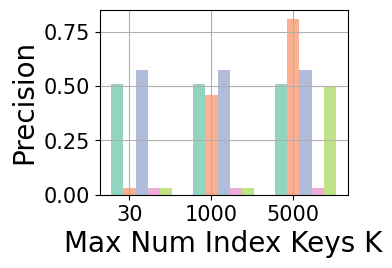

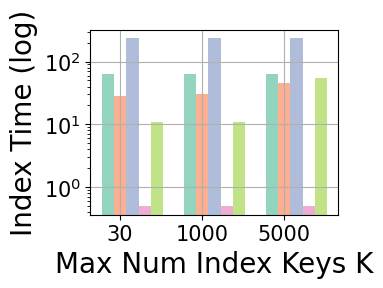

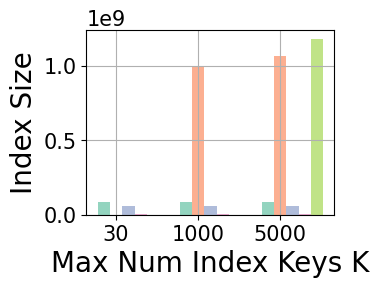

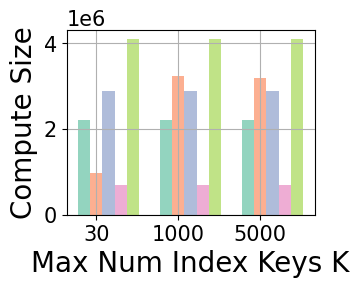

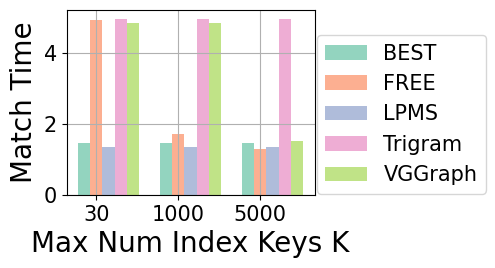

In [65]:
colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494']
for col in ['precision', 'overall_index_time', 'index_size', 'compute_size', 'overall_match_time']:
    # fig, ax = plt.subplots(figsize=(10,4.8))
    # fig, ax = plt.subplots(figsize=(6.4,2.4))
    fig, ax = plt.subplots(figsize=(3.2, 2.4))
        
    x = np.arange(len(lims))  # the label locations
    width = 0.15
    multiplier = 0
    for method, color in zip(ALL_METHODS, colors):
        curr = overall_df.loc[overall_df["name"] == method]
        
        X = curr['key_upper_bound']
        
        offset = width * multiplier - width
        Y = curr[col].to_numpy()
        rects = ax.bar(x + offset, Y, width, alpha=0.7, label=method, color=color)
        multiplier += 1
        
    ylb = ' '.join([w.capitalize() for w in col.split('_')[-2:]])
    if col == 'overall_index_time':
        ax.set_yscale('log')
        ax.ticklabel_format(axis='x', scilimits=[-3,3])
        ylb += ' (log)'
    else:
        ax.ticklabel_format(scilimits=[-3,3])
    ax.set_ylabel(ylb)
    ax.set_xlabel('Max Num Index Keys K')

    ax.set_xticks(ticks=x, labels=[f'{int(v)}' for v in lims])
    
    # plt.legend(loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.15))
    # plt.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.4))
    if col == 'overall_match_time':
        plt.legend(loc='lower center', ncol=1, bbox_to_anchor=(1.35, -0.05))
    plt.grid()
    plt.savefig(f'figs/{FIG_PREFIX}_{col}.pdf', bbox_inches='tight')
    plt.show()

In [ ]:
colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494']
for col in ['precision', 'overall_index_time', 'index_size', 'compute_size']:
    # fig, ax = plt.subplots(figsize=(4,2.8))
    
    # fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, width_ratios=(0.75,0.25), figsize=(4,2.8))
    # fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, gridspec_kw={'width_ratios': [3, 1]}, figsize=(4,2.8))
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, gridspec_kw={'width_ratios': [3, 1]}, figsize=(4,2.8))
    fig.subplots_adjust(hspace=0.01)  # adjust space between Axes
    
    x = np.array(lims)-5  # the label locations
    width1 = 0.15*30  # the width of the bars
    width2 = 0.15 *200 # the width of the bars
    multiplier = 0
    for method, color in zip(['BEST', 'FREE', 'LPMS'], colors):
        curr = summary_df.loc[summary_df["name"] == method]#.sort_values('name')
        
        X = curr['key_upper_bound']
        
        # fig, ax = plt.subplots(layout='constrained')
        prev = 0
        offset = width1 * multiplier
        Y = curr[col].to_numpy()
        if col == 'compute_size':
            rects = ax1.bar(x + offset, Y, width1, alpha=0.7, color=color)
            rects = ax2.bar(x + offset, Y, width1, alpha=0.7, label=method, color=color)
        else:
            rects = ax1.bar(x + offset, Y, width1, alpha=0.7, color=color)
            rects = ax2.bar(x + offset, Y, width1, alpha=0.7, color=color)

        multiplier += 1

        curr_all_df = res_df[(res_df["method"] == method) & (res_df["num_keys"] <= lims[-1])]
        ax1.scatter(curr_all_df['num_keys'], curr_all_df[col], c=color)
        ax2.scatter(curr_all_df['num_keys'], curr_all_df[col], c=color)
        # print(res_df[(res_df['num_keys'] > 8500) & (res_df["method"] == method)])
        # print(lims[-1])
    ylb = ' '.join([w.capitalize() for w in col.split('_')[-2:]])
    if col == 'overall_index_time':
        ax1.set_yscale('log')
        ax2.set_yscale('log')

        ylb += ' (log)'
        # ax1.ticklabel_format(axis='x', scilimits=[-3,3])
        # ax2.ticklabel_format(axis='x', scilimits=[-3,3])
    # else:
    #     ax1.ticklabel_format(scilimits=[-3,3])
    #     ax2.ticklabel_format(scilimits=[-3,3])

    # zoom-in / limit the view to different portions of the data
      
    ax1.set_xlim(0, 40)  
    ax2.set_xlim(9990, 10010)  
    ax1.set_ylabel(ylb)
    # ax1.set_xscale('log')

    # hide the spines between ax and ax2
    ax1.spines.right.set_visible(False)
    ax2.spines.left.set_visible(False)
    ax2.tick_params(axis='y', which='both', left=False)  

    ax1.set_xticks(ticks=lims[:1])#, labels=[f'{int(v/1000)}k' for v in lims[1:]])
    ax2.set_xticks(ticks=lims[-1:])#, labels=[f'{int(v/1000)}k' for v in lims[1:]])
    d = .9  # proportion of vertical to horizontal extent of the slanted line
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=8,
                  linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    ax1.plot([1, 1], [1, 0], transform=ax1.transAxes, **kwargs)
    ax2.plot([0, 0], [1, 0], transform=ax2.transAxes, **kwargs)
    if col == 'compute_size':
        plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
    ax1.grid()
    ax2.grid()
    fig.text(0.5, -0.04, 'Key Upper Bound', ha='center', va='center')
    plt.savefig(f'figs/{FIG_PREFIX}_{col}.pdf', bbox_inches='tight')
    plt.show()

In [ ]:
data = np.sort(new_res_df['num_keys'].to_numpy())
fig, ax = plt.subplots(figsize=(10, 1))
ax.scatter(data, [10] * len(data))

In [ ]:
# decide the split points
def pairwise_difference(lst):
    differences = []
    prec_diffs = []
    for i in range(len(lst) - 1):
        prec_diffs.append((lst[i + 1] - lst[i])/lst[i])
        differences.append(lst[i + 1] - lst[i])
    return differences, prec_diffs
diffs, prec_diffs = pairwise_difference(data)
idxs = np.argsort(diffs)
prec_idxs = np.argsort(prec_diffs)
print(idxs)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 1))
ax.scatter(data, [10] * len(data))
ax.set_xlim([0, 10000])

for idx in prec_idxs[-9:]:
    if data[idx] < 10000:
        print(f'idx[{idx}], between {data[idx]} and {data[idx+1]} at {(data[idx] + data[idx + 1])/2}')
        curr_x = (data[idx] + data[idx + 1])/2
        ax.axvline(x=curr_x, color='red')

In [ ]:
print(bins)

In [ ]:
name_map = {
    'BEST' : '\\best ',
    'FREE' : '\\free ',
    'FAST' : '\\lpms ',
    'LPMS' : '\\lpms ',
    'Trig' : '\\trigram ',
    'VGGr': '\\vgg '
}

def check_min_cell(row, col, format_out, curr_group):
    curr_str = ''
    if row[col] == curr_group[col].min():
        curr_str += '& \cellcolor{green!50}{'
        curr_str += format_out
        curr_str += '} '
    else:
        curr_str += f'& {format_out} '
    return curr_str

def check_max_cell(row, col, format_out, curr_group):
    curr_str = ''
    if row[col] == curr_group[col].max():
        curr_str += '& \cellcolor{yellow!50}{'
        curr_str += format_out
        curr_str += '} '
    else:
        curr_str += f'& {format_out} '
    return curr_str
summary_df = None
for up_lim in bins[2:]:
    up_lim = np.ceil(up_lim)
    curr_df = new_res_df[new_res_df['num_keys'] <= up_lim]
    curr_group = curr_df.sort_values(by=['precision', 'overall_time'], ascending=[False, True]).groupby(['method']).first()
    curr_group = curr_group.sort_values(by='num_keys')
    count = 0
    curr_row_count = curr_group.shape[0]
    curr_group['max_key'] = [up_lim]*curr_row_count
    if summary_df is None:
        summary_df = curr_group
    else:
        summary_df = pd.concat([summary_df, curr_group], ignore_index=True)

    for _, row in curr_group.iterrows():
        curr_str = ''
        count += 1;
        if count == 1:
            curr_str += '\multirow{'+str(curr_row_count)+'}{*}{\\bf{'+str(int(up_lim))+'}}'
        curr_str += f'& {name_map[row["name"][:4]]} '

        curr_str += check_min_cell(row, 'overall_match_time', f'{row["overall_match_time"]:.1f}', curr_group)
        curr_str += check_min_cell(row, 'overall_index_time', f'{row["overall_index_time"]:.0f}', curr_group)
        curr_str += check_min_cell(row, 'compute_size', f'{row["compute_size"]/1000000:.3f}', curr_group)
        curr_str += check_min_cell(row, 'index_size', f'{row["index_size"]/1000000:.1f}', curr_group)
        curr_str += check_max_cell(row, 'precision', f'{row["precision"]:.3f}', curr_group)
        print(curr_str, end='')
        if count < curr_row_count:
            print("\\\\ \cline{2-7}")
        else:
            print("\\\\ \hline")
    # print(curr_group)

In [ ]:
summary_df

In [ ]:
edges = 10**bins
prev = 0
for b in edges:
    print(new_res_df[(new_res_df['num_keys'] < b) & (new_res_df['num_keys'] >= prev)].sort_values(by='num_after_filter', ascending=True)[['name', 'num_keys', 'selection_time', 'num_after_filter']])
    prev = b
print([int(e) for e in edges])

In [ ]:
sns.histplot(new_res_df['num_keys'], bins=BIN_NUM, log_scale=True)

In [ ]:
prev = 0
for b in bins:
    print(new_res_df[(new_res_df['num_keys'] < b) & (new_res_df['num_keys'] >= prev)].sort_values(by='num_after_filter', ascending=True))
    prev = b

In [ ]:
def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))
x = new_res_df['num_keys'].to_numpy()
n, bins, patches = plt.hist(x, histedges_equalN(x, 20))

In [ ]:
prev = 0
for b in bins:
    print(new_res_df[(new_res_df['num_keys'] < b) & (new_res_df['num_keys'] >= prev)].sort_values(by='num_after_filter', ascending=True))
    prev = b

In [ ]:
best_df = res_df[res_df['name'].str.contains('BEST')]

In [ ]:
free_df = res_df[(res_df['name'] == 'FREE') | (res_df['name'] == 'FREE-parallel')]

In [ ]:
# free with c = 0.1, plot false positive rate against gramsize 
# free_df = res_df[(res_df['name'] == 'FREE') | (res_df['name'] == 'FREE-parallel')]
temp_free = free_df[free_df['selectivity'] == 0.1]

In [ ]:
# gram size vs accuracy
temp = temp_free[temp_free['num_threads'] == 1]
ax = plt.subplot()
x = temp['gram_size']
y = (temp['num_after_filter'] - temp['match_count']) / temp['num_after_filter']
ax.plot(x, y) 
plt.xlabel('Max Gram Size')
plt.ylabel('False Positive Rate')
plt.show()

In [ ]:
# gram size vs index size; gram size vs index build time
fig, axs = plt.subplots(2,1, gridspec_kw={'height_ratios': [2, 1]}, sharex=True)

colors = ['#66c2a5','#fc8d62','#8da0cb']

temp = temp_free[temp_free['num_threads'] == 1]
x = temp['gram_size']
y_1 = temp['overall_index_time']
y_1_1 = temp['selection_time']
y_1_2 = temp['build_time']

y_2 = temp['num_keys']

axs[0].stackplot(x, y_1_1, y_1_2, labels=[
    'Gram Selection', 'Posting Lists Filling' #, 'Overall Index Construction'
],
    colors=colors[:-1])

# axs[0].plot(x, y_1, label='Overall Index Construction') 
# axs[0].plot(x, y_1_1, label='Gram Selection') 
# axs[0].plot(x, y_1_2, label='Posting Lists Filling') 
axs[0].set_ylabel('Time (s)')
axs[0].legend(loc='upper left')

axs[1].plot(x, y_2, marker='o', c=colors[-1])
axs[1].set_ylabel('Num Selected')

plt.xlabel('Max Gram Size')
plt.savefig(f'figs/{FIG_PREFIX}free_n_vs_index-time_num-keys.pdf', bbox_inches='tight')

plt.show()

In [ ]:
# thread vs. build time; label by gram size
ax = plt.subplot()
seq_colors = sns.color_palette("flare")#, as_cmap=True)
for i, gram_size in enumerate(temp_free['gram_size'].unique()):
    temp = temp_free[temp_free['gram_size'] == gram_size]
    x = temp['num_threads']
    y = temp['overall_index_time']
    ax.plot(x, y, label='FREE max {}-grams'.format(int(gram_size)), marker='o', color=seq_colors[i]) 
# ax.set_facecolor('gainsboro')
plt.xlabel('Number of Threads')
plt.ylabel('Index Building Time (s)')
plt.legend() 
plt.savefig(f'figs/{FIG_PREFIX}free_thread_vs_index-time.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# thread vs. build time; label by gram size
# temp_best = best_df[best_df['selectivity'] == 0.05]
# print(temp_best)
ax = plt.subplot()
seq_colors = sns.color_palette("crest")#, n_colors=11)#, as_cmap=True)
# for i, sel in enumerate(best_df['selectivity'].unique()):
for i, sel in enumerate([0.01, 0.05,0.1, 0.2]):
    temp = best_df[best_df['selectivity'] == sel]
    x = temp['num_threads']
    y = temp['overall_index_time']
    ax.plot(x, y, label='BEST c <= {}'.format(sel), marker='o', color=seq_colors[i]) 
# ax.set_facecolor('gainsboro')
plt.xlabel('Number of Threads')
plt.ylabel('Index Building Time (s)')
plt.legend() 
plt.savefig(f'figs/{FIG_PREFIX}_best_thread_vs_index-time.pdf', bbox_inches='tight')
plt.show()